In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import statsmodels.api as sm
import pandas as pd
import numpy as np
from scipy import stats
from wordcloud import WordCloud
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
from statsmodels.sandbox.stats.multicomp import multipletests

In [2]:
sns.set_style({'font.family':"sans-serif"})
sns.set_style('darkgrid')

**Methods and definitions.**

In [3]:
def my_pie(data, group, title, ax=None, figsize=None):
    data.groupby([group]).size().plot.pie(
        title=title, 
        ylabel='', 
        autopct=lambda p:'{:.1f}% ({:.0f})'.format(p, (p/100)*data.groupby([group]).size().sum()),
        figsize=figsize,
        ax=ax
    )

def my_bar(data, group, title, ax=None, figsize=None):
    ax_t = data.groupby([group]).size().plot.bar(
        title=title, 
        ylabel='count', 
        figsize=figsize,
        ax=ax
    )
    ax_t.bar_label(ax_t.containers[0])

def my_hist_with_qq(data, column, title, xlabel, figsize=(15, 6)):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=figsize)
    data[column].plot.hist(title=title, ax=ax1)
    ax1.set_xlabel(xlabel)
    
    with mpl.rc_context():
        mpl.rc("figure", figsize=(3,3))
        sm.qqplot(data[column], line ='45', fit=True, ax=ax2)

def my_count(data, column, title, ax=None, order=None):
    fig, ax_t = plt.subplots()
    ax_t = sns.countplot(
        y = column, 
        data = data, 
        order = order, 
        ax=ax,
        palette='deep'
    )
    ax_t.bar_label(ax_t.containers[0])
    ax_t.set_title(title)

def my_box(data, columns, title, xlabel='count', ax=None, figsize=None):
    fig, ax_t = plt.subplots(figsize=figsize)
    ax_t = sns.boxplot(
        data=data[[x for x in data.columns if x in columns]],
        orient='h',
        ax=ax,
        palette='deep'
    ).set(xlabel=xlabel, title=title)

def my_box_xy(data, x, y, title, xlabel='count', ax=None, order=None):
    if(not ax):
        fig, ax_t = plt.subplots()
    sns.boxplot(
        data=data,
        orient='h',
        ax=ax,
        x=x,
        y=y,
        palette='deep',
        order=order
    ).set(xlabel=xlabel, title=title)
    
def my_dist(data, x, hue, title):
    sns.displot(
        data=data, 
        x=x, 
        hue=hue, 
        kind="kde",
    ).set(title=title)
    
def my_test(test, data, column, group, title):
    print(title)
    cols = [data[data[group] == x][column] for x in data[group].unique()]
    stat = test(*cols)
    print("{low}pvalue: {p}\n".format(p=stat.pvalue, low='----> ' if stat.pvalue < 0.05 else ' '))

    if(stat.pvalue < 0.05 and test == stats.kruskal):
        p_vals = []

        for comb in list(combinations(cols, 2)):
            stat = stats.mannwhitneyu(*comb)
            p_vals.append(stat.pvalue)

        reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]

        print('Post-hoc testing:')
        combs = list(combinations(data[group].unique(), 2))
        for index, comp in enumerate(combs):
            print('{:20}{:20}{:20}'.format(str(combs[index]), corrected_p_vals[index], reject_list[index]))
        print('\n\n')
        

def my_chi(data, group1, group2, merge_index=False, merge_cols=False):
    counts = data.groupby([group1, group2]).size().unstack().fillna(0)
    
    if(merge_index):
        for index in merge_index:
            for index2 in merge_index[index]:
                counts.loc[index] = counts.loc[index] + counts.loc[index2]
                counts = counts.drop(axis=0, index=[index2])
        
    if(merge_cols):
        for col in merge_cols:
            for col2 in merge_cols[col]:
                counts.loc[:, col] = counts.loc[:, col] + counts.loc[:, col2]
                counts = counts.drop(axis=1, columns=[col2])
                
    print(counts, end='\n\n')
    
    stat, p, d, exp = stats.chi2_contingency(counts)
    print("{low}pvalue: {p}\n".format(p=p, low='----> ' if p < 0.05 else ''))
    print('expected frequencies:')
    print(exp, end='\n\n')
    
    if(p < 0.05):
        p_vals = []

        for comb in list(combinations(counts.columns, 2)):
            new_df = counts[[comb[0], comb[1]]]
            chi2, p, dof, ex = stats.chi2_contingency(new_df)
            p_vals.append(p)
        with np.errstate(divide='ignore'):
            reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_gbs')[:2]

        print('Post-hoc testing:')
        combs = list(combinations(counts.columns, 2))
        for index, comp in enumerate(combs):
            print('{:20}{:20}{:20}'.format(str(combs[index]), corrected_p_vals[index], reject_list[index]))
        print('\n\n')

def my_bar_grouped(data, column, group, title, hue_order=None, ax=None):
    plt.figure(tight_layout=True)
    ax_t = sns.barplot(
        data=data.groupby([column, group]).size().reset_index(), 
        y=0, 
        x=column, 
        hue=group,
        palette='deep',
        linewidth=2,
        hue_order = hue_order,
        ax=ax
    ).set(title=title, xlabel=column, ylabel='count')

def my_mean_plot(data, columns, group, title, label_x=None, label_y=None, order=None):
    if(not order):
        data.groupby([group]).mean().reset_index().plot(x = group, y= columns, title=title, figsize=(5, 3))
    else:
        data.groupby([group]).mean().loc[order].reset_index().plot(x = group, y= columns, title=title, figsize=(5, 3))
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    
def my_heatmap(data, columns):
    corr = data[columns].corr(method='spearman')
    sns.heatmap(corr, annot=True)
    
def multiple_tests(test, columns, labels):
    p_vals = []

    for comb in list(combinations(columns, 2)):
        stat = test(*comb)
        p_vals.append(stat.pvalue)

    if(test == stats.kruskal or test == stats.mannwhitneyu):
        reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]
    if(test == stats.chi2_contingency):
        reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_gbs')[:2]

    print('Post-hoc testing:')
    print(list(combinations(labels, 2)))
    print(corrected_p_vals)
    print(reject_list, end='\n\n\n')
    
def my_test2(test, followup_test, columns, title, labels):
    print(title)
    stat = test(*columns)
    for i in range(len(columns)):
        print(labels[i] + ' mean: ' + str(columns[i].mean()))
        print(labels[i] + ' std: ' + str(columns[i].std()))
    print("\n{low}pvalue: {p}\n".format(p=stat.pvalue, low='----> ' if stat.pvalue < 0.05 else ' '))
    
    if(stat.pvalue < 0.05 and len(columns) > 2):
        multiple_tests(stats.mannwhitneyu, columns, labels)
    

attrak = {
    'PQ1': 'complicated - simple', 
    'PQ2': 'impractical - practical', 
    'PQ3': 'unpredictable - predictable', 
    'PQ4': 'confusing - clearly constructed', 
    'HQ1': 'tacky - stylish', 
    'HQ2': 'cheap - premium', 
    'HQ3': 'unimaginative - creative', 
    'HQ4': 'dull - captivating', 
    'ATT1': 'ugly - attractive', 
    'ATT2': 'bad - good',
    'PQ': 'All pragmatic qualities',
    'HQ': 'All hedonic qualities',
    'ATT': 'All attractiveness qualities'
}

open_text = {
    'company': 'Company\'s name',
    'purpose': 'Company\'s purpose',
    'purpose_token_count': 'Number of full meaning words in purpose',
    'purpose_word_count': 'Number of words in purpose question',
    'detail': 'Website\'s detail',
    'desc_eval_comp': 'Description complexity',
    'desc_eval_elem': 'Number of identified elements in description',
    'desc_eval_char': 'Number of identified characterists in description',
    'desc_eval_sum': 'Sum of identified characteristics and elements in description',
    'desc_token_count': 'Number of full meaning words in description',
    'desc_word_count': 'Number of words in description'
}

# Time intervals analysis

**Load data**

In [4]:
data = pd.read_csv("../data/results.csv", index_col=0)
respondents = pd.read_csv("../data/respondents.csv", index_col=0)

**Mean.**

In [5]:
data[['interval'] + list(attrak.keys())].groupby(['interval']).mean().sort_index(
    key=lambda x: x.map({'2s' : 0, '5s': 1, '10s' : 2})
)

PQ1       PQ2       PQ3       PQ4       HQ1       HQ2  \
interval                                                               
2s        4.570833  4.929167  4.787500  4.750000  4.216667  4.066667   
5s        4.616667  4.983333  4.837500  4.779167  4.375000  4.137500   
10s       4.645833  5.033333  4.766667  4.804167  4.354167  4.066667   

               HQ3       HQ4      ATT1      ATT2        PQ        HQ       ATT  
interval                                                                        
2s        3.783333  4.050000  4.295833  4.616667  4.759375  4.029167  4.456250  
5s        4.004167  4.120833  4.445833  4.608333  4.804167  4.159375  4.527083  
10s       3.845833  3.966667  4.425000  4.525000  4.812500  4.058333  4.475000

In [6]:
data[['interval'] + list(open_text.keys())].groupby(['interval']).mean().sort_index(
    key=lambda x: x.map({'2s' : 0, '5s': 1, '10s' : 2})
)

company   purpose  purpose_token_count  purpose_word_count  \
interval                                                                
2s        0.897917  0.758333             2.441667               4.050   
5s        0.950000  0.843750             2.658333               4.300   
10s       0.937500  0.933333             2.812500               4.225   

            detail  desc_eval_comp  desc_eval_elem  desc_eval_char  \
interval                                                             
2s        0.214583        0.766667        1.358333        0.416667   
5s        0.287500        0.912500        1.387500        0.595833   
10s       0.329167        1.095833        1.870833        0.333333   

          desc_eval_sum  desc_token_count  desc_word_count  
interval                                                    
2s             1.775000          8.670833        19.145833  
5s             1.983333         10.116667        22.137500  
10s            2.204167         10.850000        22.450000

**Median.**

In [7]:
data[['interval'] + list(attrak.keys())].groupby(['interval']).median().sort_index(
    key=lambda x: x.map({'2s' : 0, '5s': 1, '10s' : 2})
)

PQ1  PQ2  PQ3  PQ4  HQ1  HQ2  HQ3  HQ4  ATT1  ATT2    PQ    HQ  ATT
interval                                                                     
2s        5.0  5.0  5.0  5.0  4.0  4.0  4.0  4.0   4.0   5.0  4.75  4.00  4.5
5s        5.0  5.0  5.0  5.0  4.0  4.0  4.0  4.0   5.0   5.0  5.00  4.25  5.0
10s       5.0  5.0  5.0  5.0  4.0  4.0  4.0  4.0   5.0   5.0  5.00  4.00  4.5

In [8]:
data[['interval'] + list(open_text.keys())].groupby(['interval']).median().sort_index(
    key=lambda x: x.map({'2s' : 0, '5s': 1, '10s' : 2})
)

company  purpose  purpose_token_count  purpose_word_count  detail  \
interval                                                                      
2s            1.0      1.0                  2.0                 3.0     0.0   
5s            1.0      1.0                  2.0                 3.0     0.0   
10s           1.0      1.0                  3.0                 4.0     0.0   

          desc_eval_comp  desc_eval_elem  desc_eval_char  desc_eval_sum  \
interval                                                                  
2s                   1.0             1.0             0.0            2.0   
5s                   1.0             1.0             0.0            2.0   
10s                  1.0             2.0             0.0            2.0   

          desc_token_count  desc_word_count  
interval                                     
2s                     7.0             15.0  
5s                     8.0             15.0  
10s                   10.0             19.5

**Std.**

In [9]:
data[['interval'] + list(attrak.keys())].groupby(['interval']).std().sort_index(
    key=lambda x: x.map({'2s' : 0, '5s': 1, '10s' : 2})
)

PQ1       PQ2       PQ3       PQ4       HQ1       HQ2  \
interval                                                               
2s        1.509795  1.315813  1.306825  1.487746  1.304536  1.342784   
5s        1.731729  1.480604  1.310822  1.645707  1.319709  1.329521   
10s       1.531941  1.322058  1.275671  1.568246  1.259102  1.308059   

               HQ3       HQ4      ATT1      ATT2        PQ        HQ       ATT  
interval                                                                        
2s        1.323640  1.324693  1.455039  1.348691  1.198485  1.161707  1.324520  
5s        1.388831  1.389584  1.583513  1.410041  1.330242  1.212240  1.405420  
10s       1.327684  1.331519  1.406277  1.247340  1.219502  1.148144  1.238926

In [10]:
data[['interval'] + list(open_text.keys())].groupby(['interval']).std().sort_index(
    key=lambda x: x.map({'2s' : 0, '5s': 1, '10s' : 2})
)

company   purpose  purpose_token_count  purpose_word_count  \
interval                                                                
2s        0.291073  0.416618             1.896025            4.312772   
5s        0.198319  0.329134             2.145330            5.482723   
10s       0.224657  0.208936             1.489942            3.038009   

            detail  desc_eval_comp  desc_eval_elem  desc_eval_char  \
interval                                                             
2s        0.402393        0.799930        1.049374        0.634877   
5s        0.444221        0.889649        1.114684        0.736939   
10s       0.468666        0.893481        1.324055        0.576141   

          desc_eval_sum  desc_token_count  desc_word_count  
interval                                                    
2s             1.247340          5.675682        14.625863  
5s             1.260825          7.392955        19.099877  
10s            1.373686          6.277608        14.283062

**Histograms**

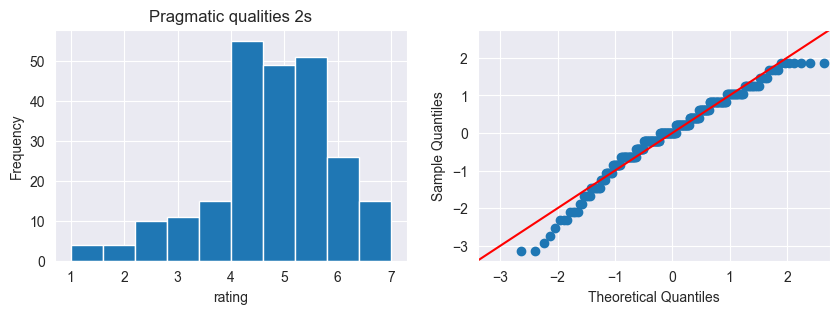

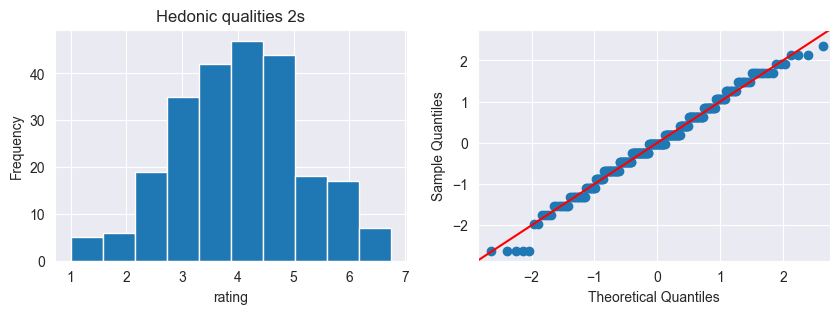

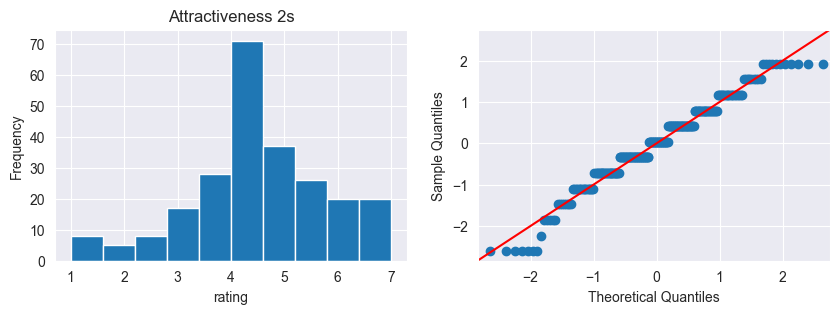

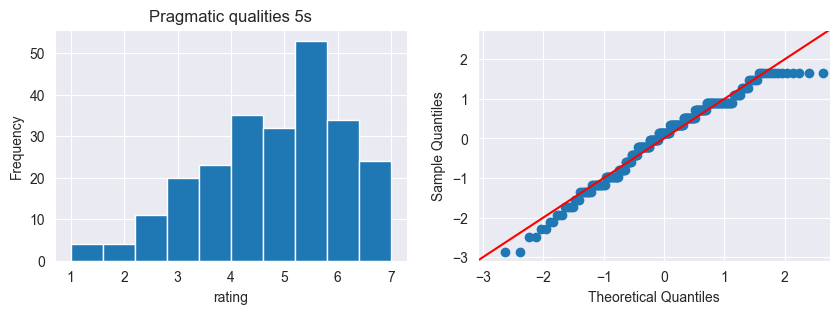

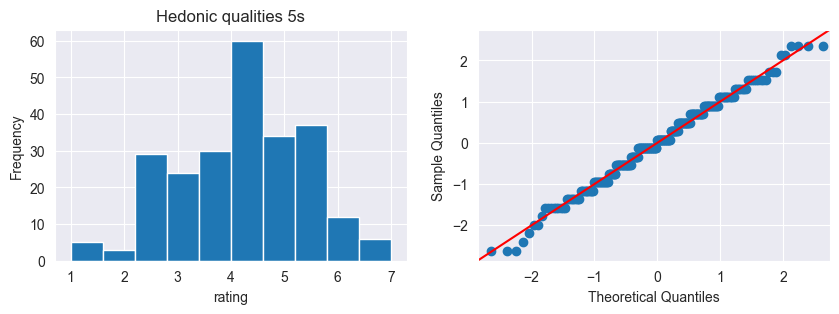

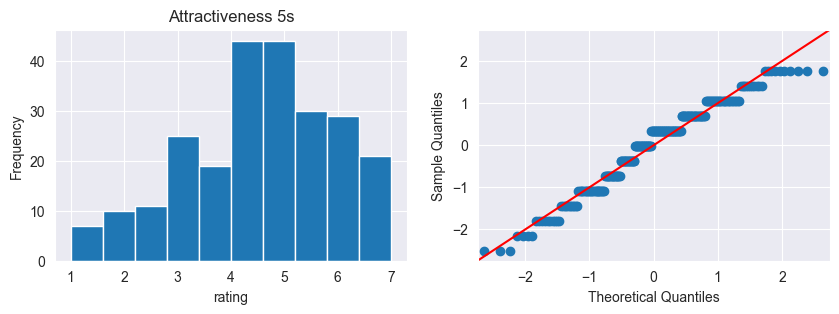

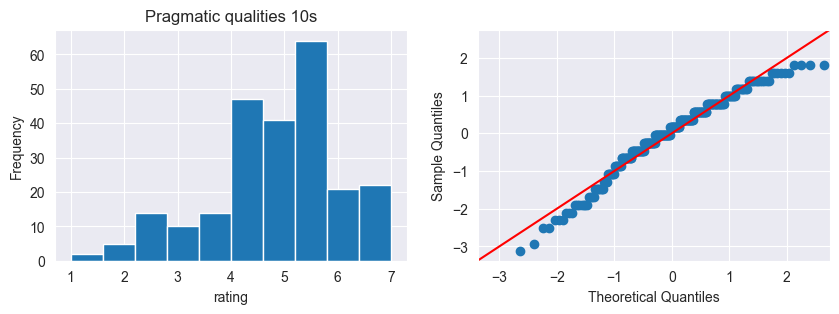

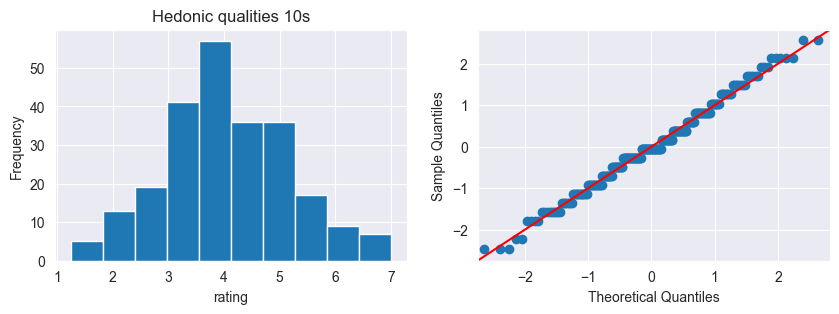

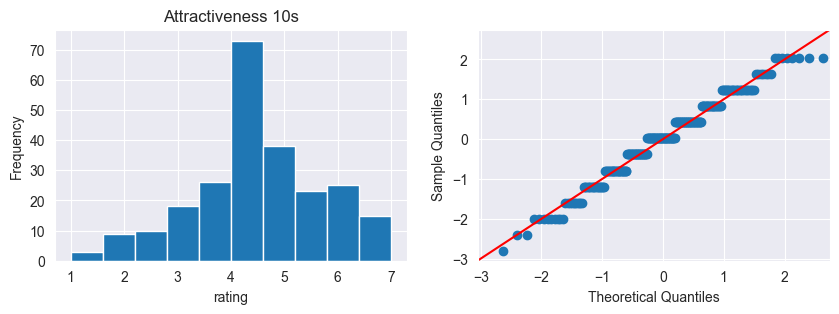

In [11]:
for interval in ['2s', '5s', '10s']:
    my_hist_with_qq(data[data.interval == interval], 'PQ', 'Pragmatic qualities ' + interval, 'rating', (10, 3))
    my_hist_with_qq(data[data.interval == interval], 'HQ', 'Hedonic qualities ' + interval, 'rating', (10, 3))
    my_hist_with_qq(data[data.interval == interval], 'ATT', 'Attractiveness ' + interval, 'rating', (10, 3))

In [12]:
for column in ['PQ', 'HQ', 'ATT']:
    for interval in ['2s', '5s', '10s']:
        print(column + ' ' + interval)
        print(stats.shapiro(data[data.interval == interval][column]), end='\n\n')

PQ 2s
ShapiroResult(statistic=0.968147873878479, pvalue=3.317633309052326e-05)

PQ 5s
ShapiroResult(statistic=0.9686362147331238, pvalue=3.856825060211122e-05)

PQ 10s
ShapiroResult(statistic=0.9659788608551025, pvalue=1.7217365893884562e-05)

HQ 2s
ShapiroResult(statistic=0.9880537390708923, pvalue=0.04345602169632912)

HQ 5s
ShapiroResult(statistic=0.9901587963104248, pvalue=0.10350368171930313)

HQ 10s
ShapiroResult(statistic=0.9901817440986633, pvalue=0.1044825091958046)

ATT 2s
ShapiroResult(statistic=0.9719603061676025, pvalue=0.00011081530101364478)

ATT 5s
ShapiroResult(statistic=0.9637255668640137, pvalue=8.898620762920473e-06)

ATT 10s
ShapiroResult(statistic=0.9781104326248169, pvalue=0.0009102356852963567)



**Time taken.**

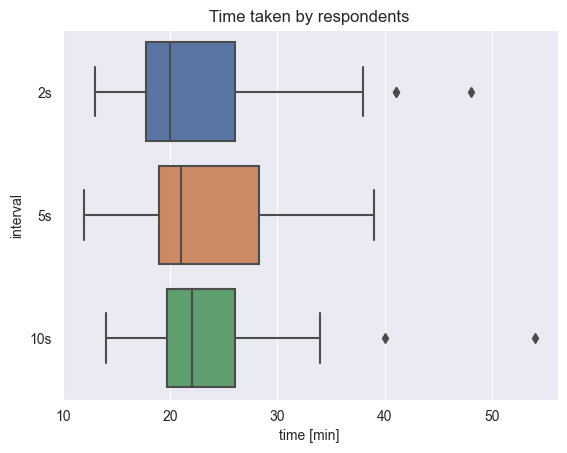

In [13]:
my_box_xy(respondents, 'time_taken', 'interval', 'Time taken by respondents', 'time [min]')

## Attrak-diff

**Boxplots**

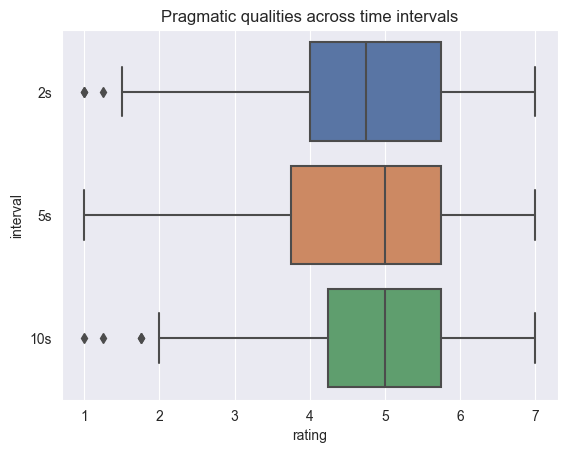

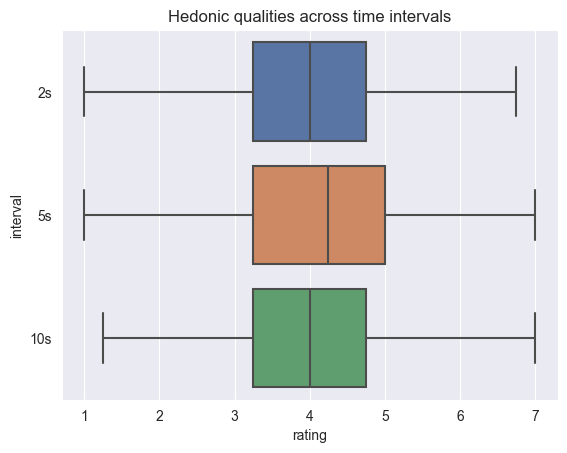

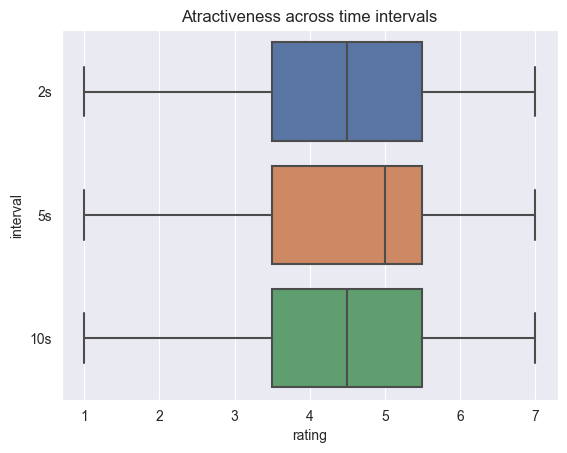

In [14]:
my_box_xy(data, 'PQ', 'interval', 'Pragmatic qualities across time intervals', 'rating')
my_box_xy(data, 'HQ', 'interval', 'Hedonic qualities across time intervals', 'rating')
my_box_xy(data, 'ATT', 'interval', 'Atractiveness across time intervals', 'rating')

**Distribution differences.**

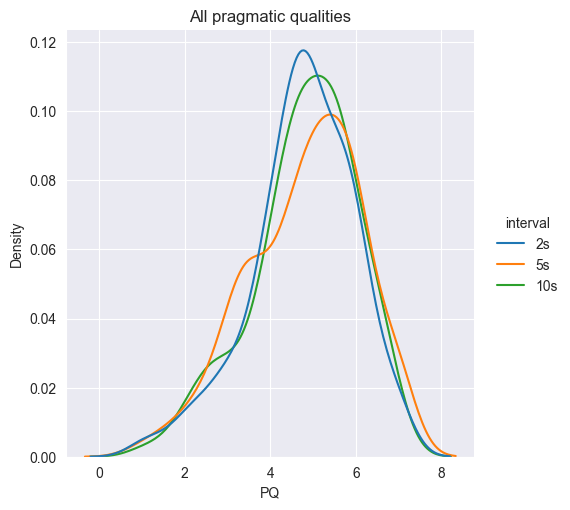

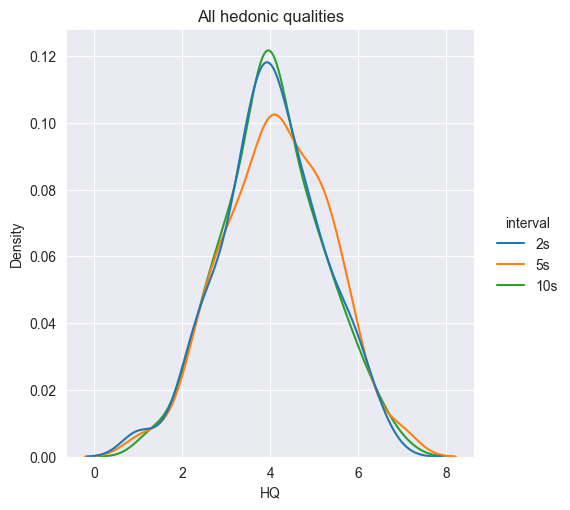

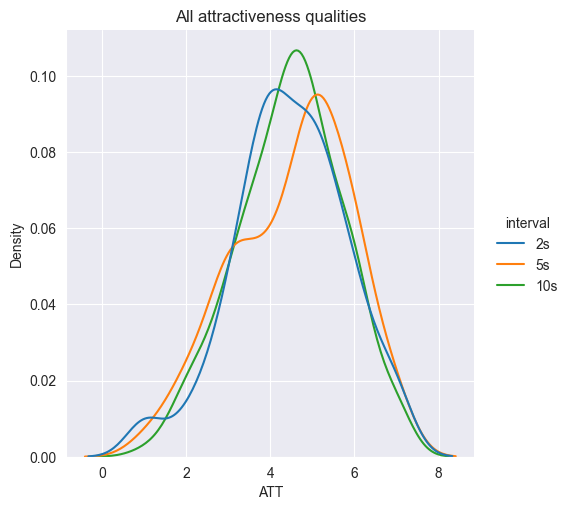

In [15]:
my_dist(data, 'PQ', 'interval', attrak['PQ'])
my_dist(data, 'HQ', 'interval', attrak['HQ'])
my_dist(data, 'ATT', 'interval', attrak['ATT'])

**Kruskal tests.**

In [16]:
for column in ['PQ', 'HQ', 'ATT']:
    my_test(stats.kruskal, data, column, 'interval', column + ' (' + attrak[column] + ')')

PQ (All pragmatic qualities)
 pvalue: 0.7428310585104998

HQ (All hedonic qualities)
 pvalue: 0.4045929665987832

ATT (All attractiveness qualities)
 pvalue: 0.6057147710114177



## Open text questions

In [17]:
fixed_data = data[(data.interval != '2s') | (data.interval == '2s') & (data.respondent != 50)]

**Company's name.**

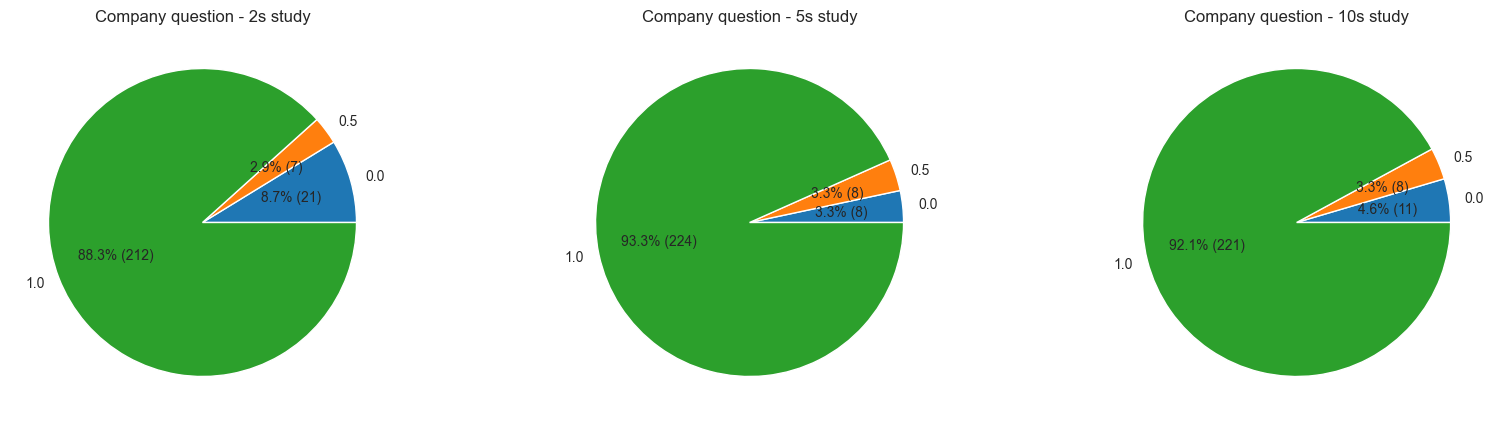

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))
my_pie(data[data.interval == '2s'], 'company', 'Company question - 2s study', ax1)
my_pie(data[data.interval == '5s'], 'company', 'Company question - 5s study', ax2)
my_pie(data[data.interval == '10s'], 'company', 'Company question - 10s study', ax3)

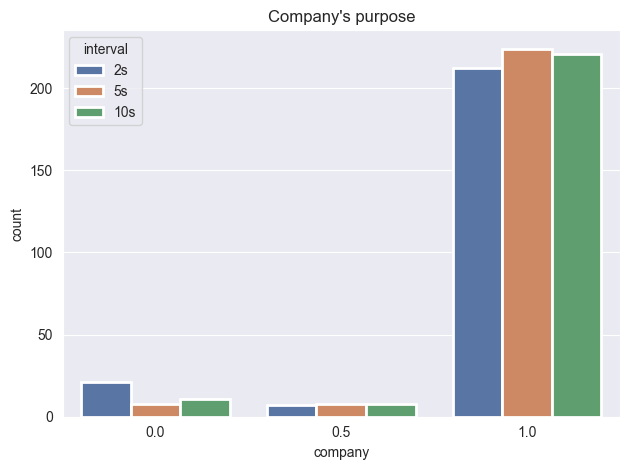

In [19]:
my_bar_grouped(data, 'company', 'interval', open_text['purpose'], ['2s', '5s', '10s'])

In [20]:
my_chi(fixed_data, 'company', 'interval')

interval  10s   2s   5s
company                
0.0        11   21    8
0.5         8    7    8
1.0       221  206  224

pvalue: 0.0970616056680957

expected frequencies:
[[ 13.44537815  13.1092437   13.44537815]
 [  7.73109244   7.53781513   7.73109244]
 [218.82352941 213.35294118 218.82352941]]



Company name on warmup question

In [21]:
stat, p, d, exp = stats.chi2_contingency([
    [9, 31],
    [13, 27],
    [18, 22]
])
print("{low}pvalue: {p}\n".format(p=p, low='----> ' if p < 0.05 else ''))
print('expected frequencies:')
print(exp, end='\n\n')

pvalue: 0.10151994473009111

expected frequencies:
[[13.33333333 26.66666667]
 [13.33333333 26.66666667]
 [13.33333333 26.66666667]]



**Company's purpose.**

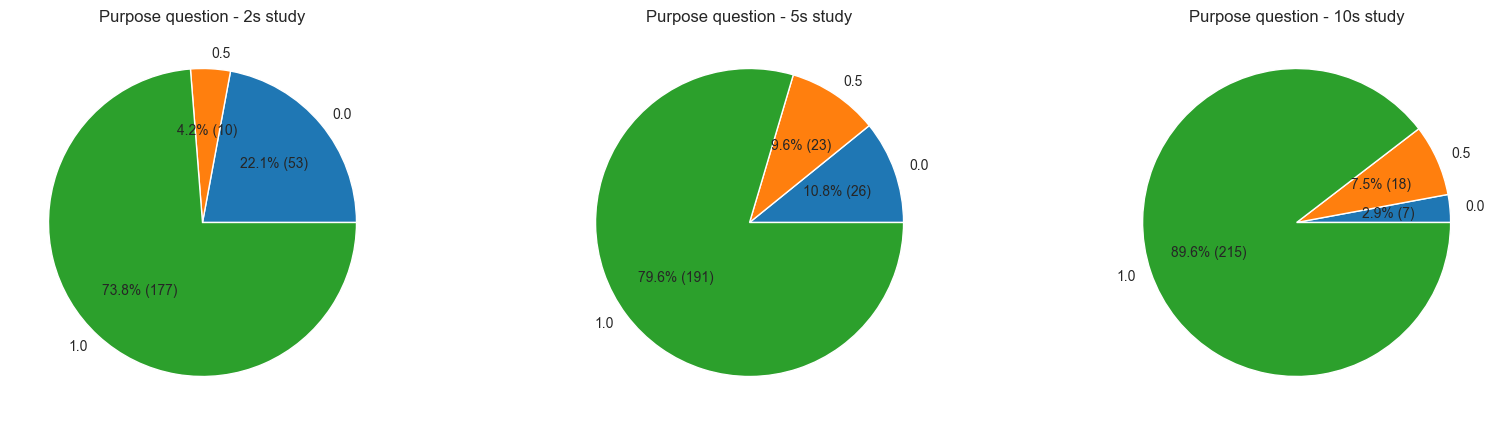

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))
my_pie(data[data.interval == '2s'], 'purpose', 'Purpose question - 2s study', ax1)
my_pie(data[data.interval == '5s'], 'purpose', 'Purpose question - 5s study', ax2)
my_pie(data[data.interval == '10s'], 'purpose', 'Purpose question - 10s study', ax3)

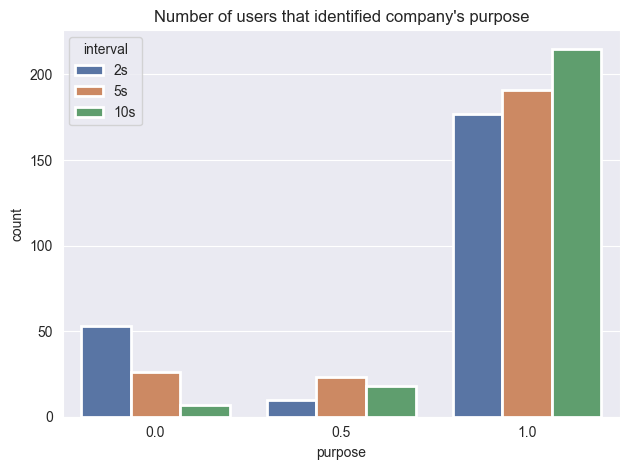

In [23]:
my_bar_grouped(data, 'purpose', 'interval', 'Number of users that identified company\'s purpose', ['2s', '5s', '10s'])

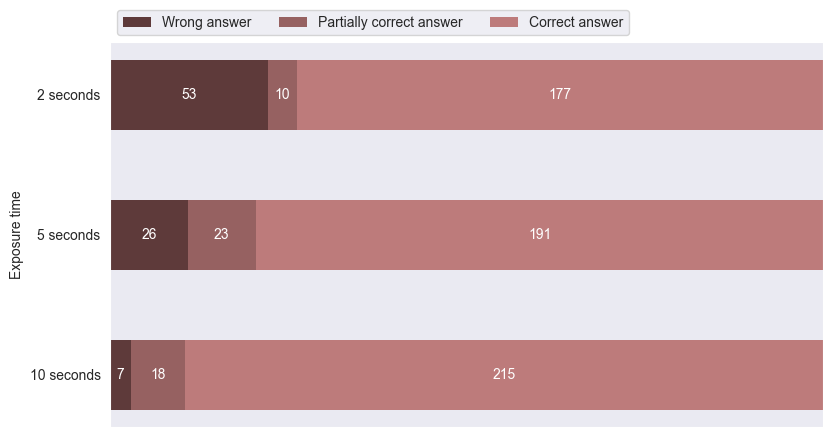

In [69]:
fig, ax = plt.subplots(figsize=(9.2, 5))
x = data.groupby(['purpose', 'interval']).size().reset_index()
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, 240)
sums = [0, 0, 0]
colors = plt.colormaps['pink'](np.linspace(0.08, 0.35, 3))
legend = ['Wrong answer', 'Partially correct answer', 'Correct answer']
for index, i in enumerate([0, 0.5, 1]):
    curr_sum = [
        int(x[(x.purpose == i) & (x.interval == '2s')][0]),
        int(x[(x.purpose == i) & (x.interval == '5s')][0]),
        int(x[(x.purpose == i) & (x.interval == '10s')][0])
    ]
    r = ax.barh(
        ['2 seconds', '5 seconds', '10 seconds'],
        curr_sum,
        left=sums,
        height=0.5, 
        label=legend[index],
        color=colors[index],
        linewidth=0
    )
    ax.bar_label(r, label_type='center', color='white')
    ax.legend(ncol=len(legend), bbox_to_anchor=(0, 1),
              loc='lower left')
    for j, v in enumerate(sums):
        sums[j] += curr_sum[j]
ax.set_ylabel('Exposure time')
ax.set_xlabel('Number of responses')
plt.show()

In [25]:
my_chi(fixed_data, 'purpose', 'interval')

interval  10s   2s   5s
purpose                
0.0         7   53   26
0.5        18   10   23
1.0       215  171  191

----> pvalue: 1.1731030099304519e-09

expected frequencies:
[[ 28.90756303  28.18487395  28.90756303]
 [ 17.14285714  16.71428571  17.14285714]
 [193.94957983 189.10084034 193.94957983]]

Post-hoc testing:
('10s', '2s')       1.7726675582150627e-09                   1
('10s', '5s')       0.0005100417579665899                   1
('2s', '5s')        0.00045746211920335395                   1





**Web page's detail.**

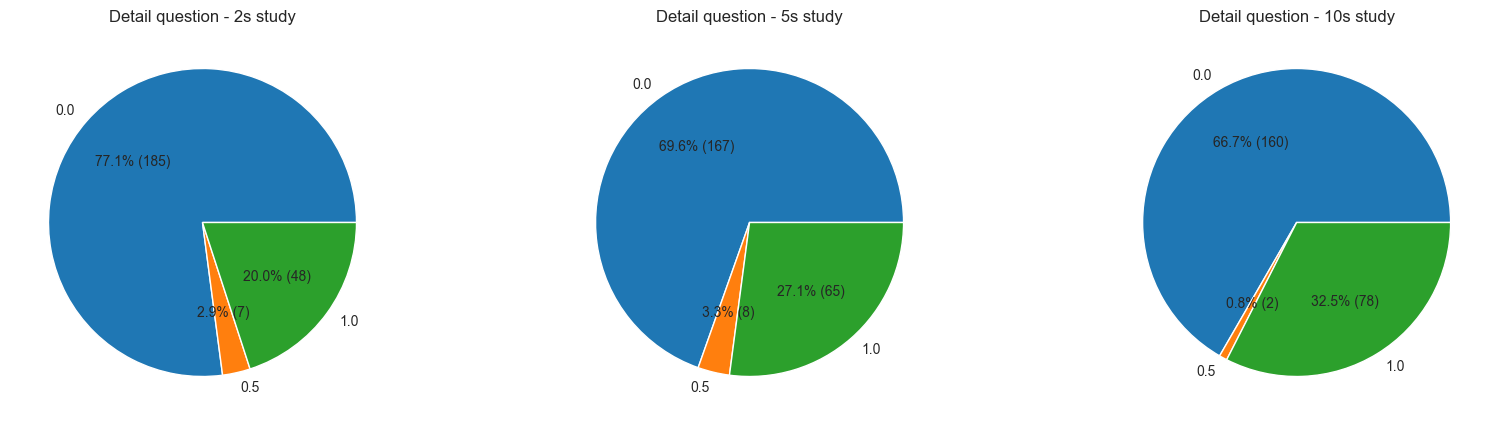

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))
my_pie(data[data.interval == '2s'], 'detail', 'Detail question - 2s study', ax1)
my_pie(data[data.interval == '5s'], 'detail', 'Detail question - 5s study', ax2)
my_pie(data[data.interval == '10s'], 'detail', 'Detail question - 10s study', ax3)

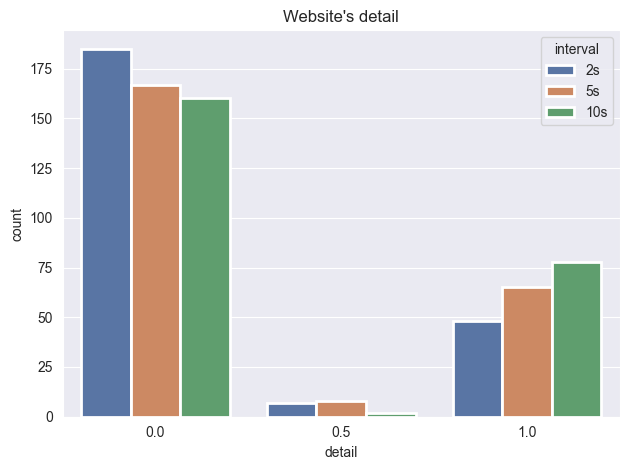

In [27]:
my_bar_grouped(data, 'detail', 'interval', open_text['detail'], ['2s', '5s', '10s'])

In [28]:
my_chi(fixed_data, 'detail', 'interval')

interval  10s   2s   5s
detail                 
0.0       160  180  167
0.5         2    7    8
1.0        78   47   65

----> pvalue: 0.014325995170690962

expected frequencies:
[[170.42016807 166.15966387 170.42016807]
 [  5.71428571   5.57142857   5.71428571]
 [ 63.86554622  62.26890756  63.86554622]]

Post-hoc testing:
('10s', '2s')       0.009256927341602574                   1
('10s', '5s')        0.09282223345102814                   0
('2s', '5s')         0.09282223345102814                   0





**Word counts (purpose, description)**

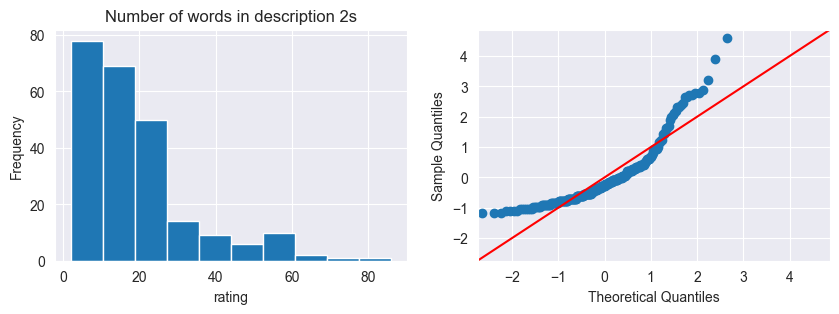

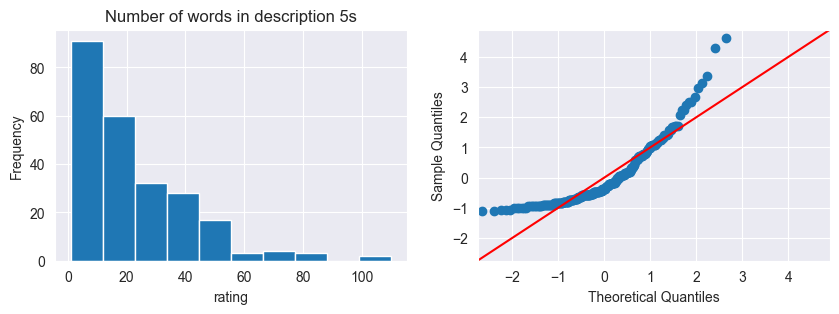

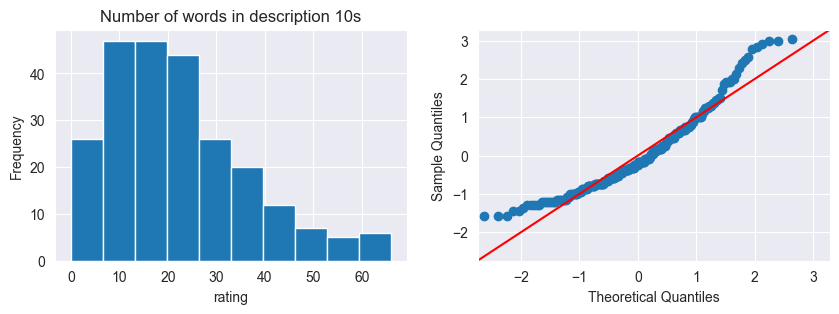

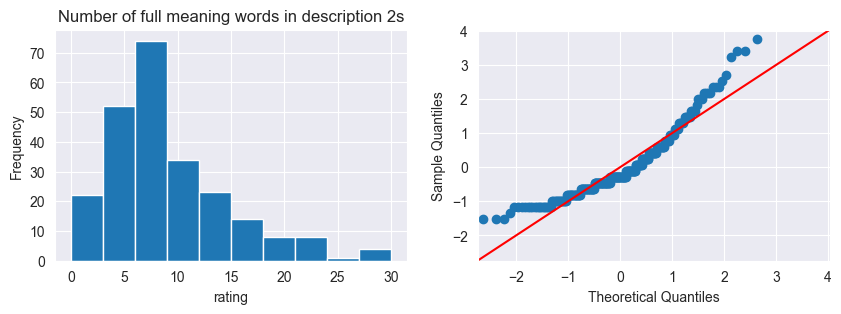

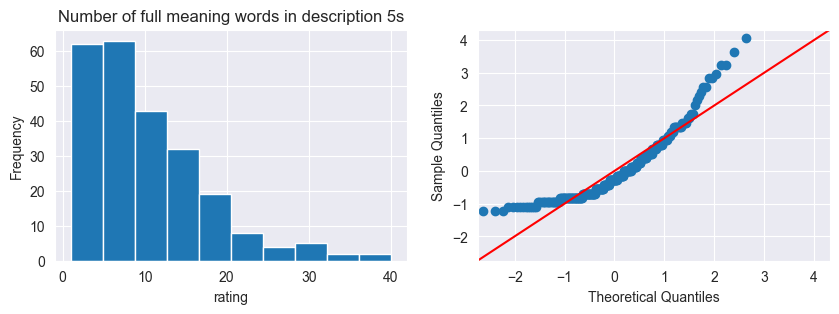

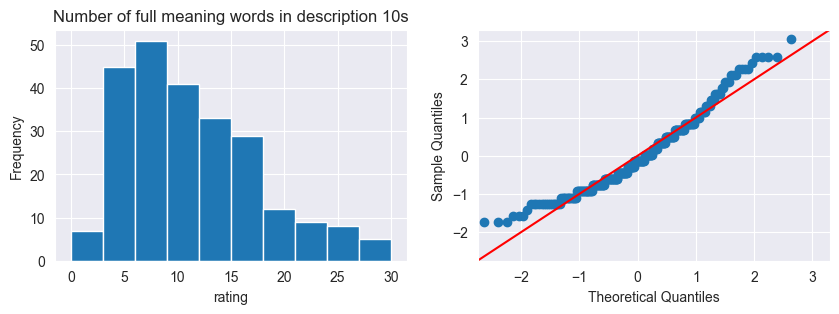

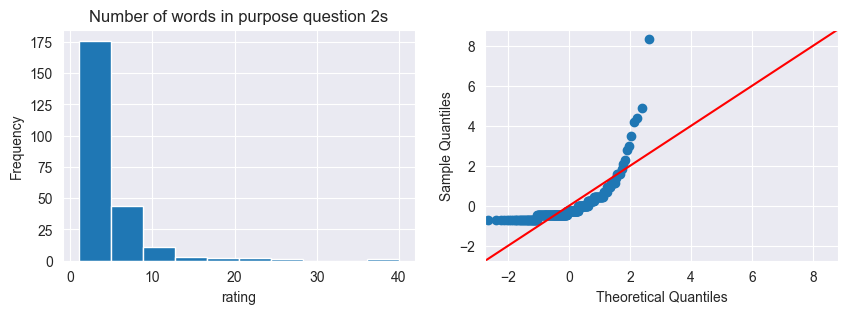

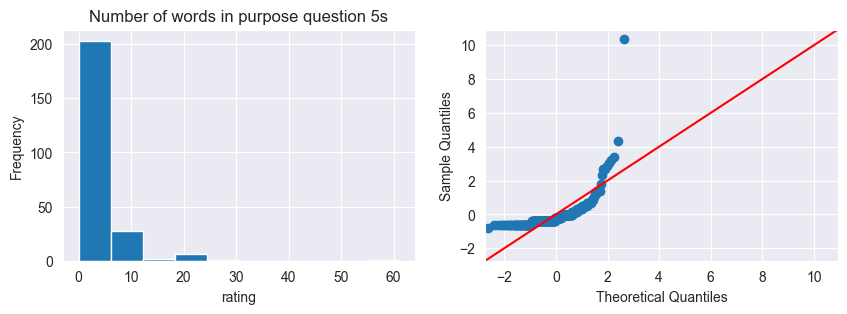

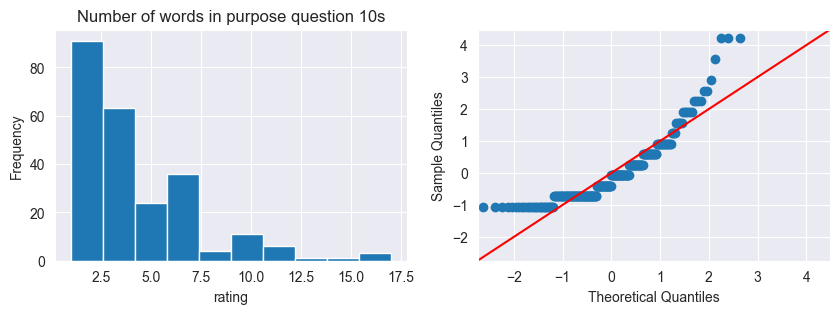

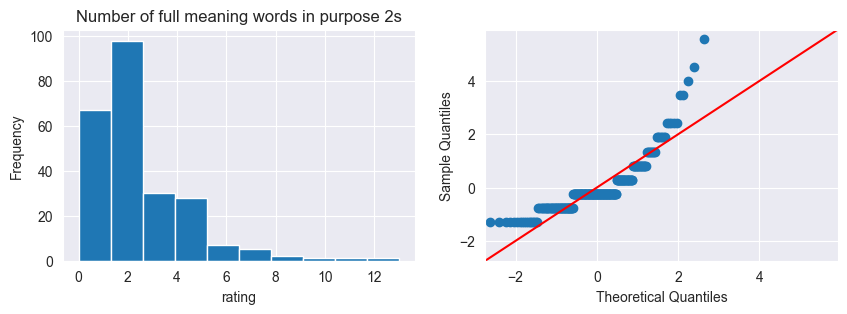

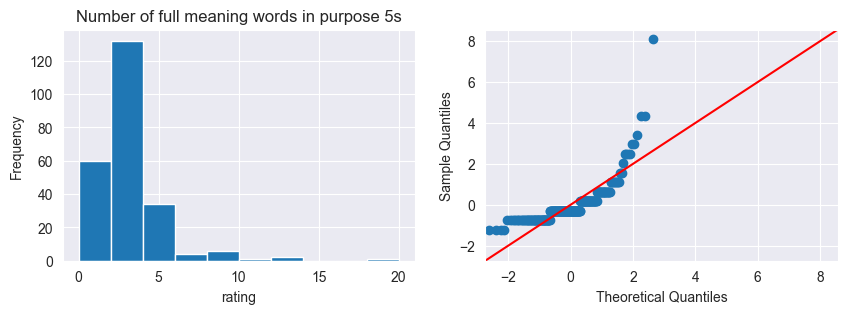

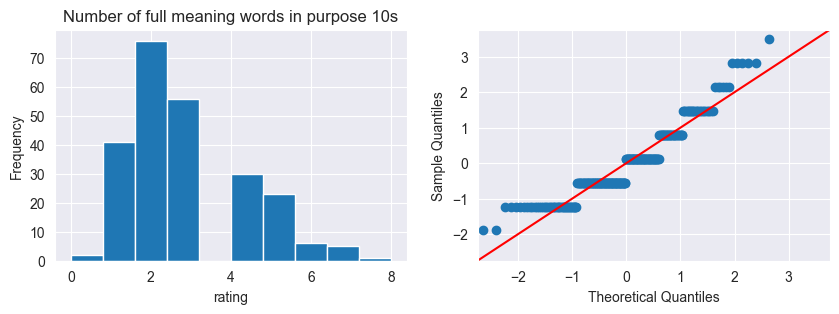

In [29]:
for column in ['desc_word_count', 'desc_token_count', 'purpose_word_count', 'purpose_token_count']:
    for interval in ['2s', '5s', '10s']:
        my_hist_with_qq(data[data.interval == interval], column, open_text[column] + ' ' + interval, 'rating', (10, 3))

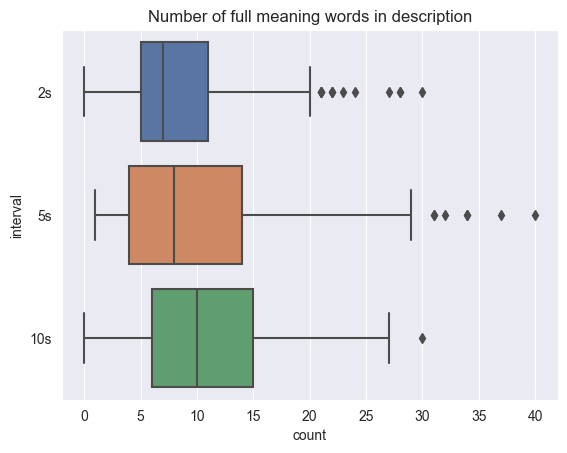

In [30]:
my_box_xy(data, 'desc_token_count', 'interval', open_text['desc_token_count'])

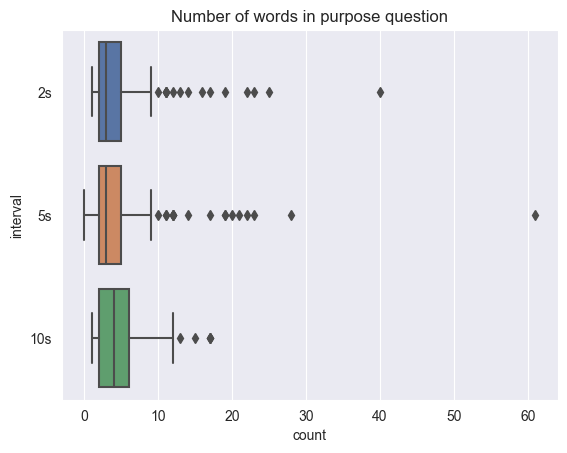

In [31]:
my_box_xy(data, 'purpose_word_count', 'interval', open_text['purpose_word_count'])

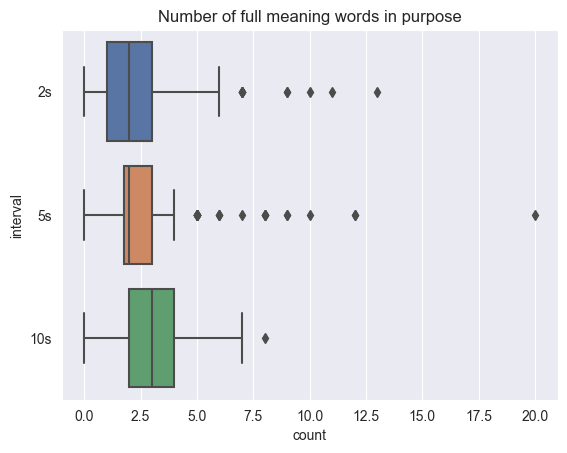

In [32]:
my_box_xy(data, 'purpose_token_count', 'interval', open_text['purpose_token_count'])

In [33]:
for column in ['desc_word_count_group', 'desc_token_count_group']:
    my_chi(fixed_data, column, 'interval')

interval               10s  2s  5s
desc_word_count_group             
high                    95  55  84
low                     55  92  91
med                     90  87  65

----> pvalue: 2.3049715275954273e-05

expected frequencies:
[[78.65546218 76.68907563 78.65546218]
 [80.         78.         80.        ]
 [81.34453782 79.31092437 81.34453782]]

Post-hoc testing:
('10s', '2s')       0.0001391183955676424                   1
('10s', '5s')       0.0011234497380062866                   1
('2s', '5s')        0.003444039721701062                   1



interval                10s   2s  5s
desc_token_count_group              
high                     88   42  72
low                      52   74  84
med                     100  118  84

----> pvalue: 5.961253853676071e-06

expected frequencies:
[[ 67.89915966  66.20168067  67.89915966]
 [ 70.58823529  68.82352941  70.58823529]
 [101.51260504  98.97478992 101.51260504]]

Post-hoc testing:
('10s', '2s')       6.331852069331584e-05       

In [34]:
for column in ['desc_word_count', 'desc_token_count']:
    my_test(stats.kruskal, data, column, 'interval', column + ' (' + open_text[column] + ')')

desc_word_count (Number of words in description)
----> pvalue: 0.004920053276883896

Post-hoc testing:
('2s', '5s')          0.4745490399440374                   0
('2s', '10s')       0.0020829719968740233                   1
('5s', '10s')        0.06591661139389324                   0



desc_token_count (Number of full meaning words in description)
----> pvalue: 0.00025590386017259416

Post-hoc testing:
('2s', '5s')         0.15030664509288552                   0
('2s', '10s')       9.348451515886201e-05                   1
('5s', '10s')        0.02966409636416182                   1





**No. of identified elements**

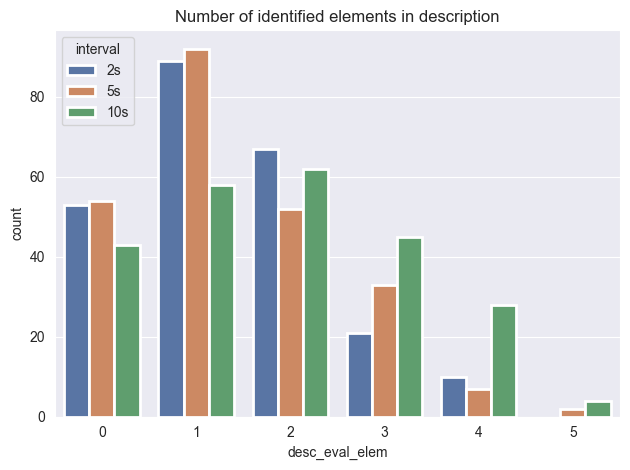

In [35]:
my_bar_grouped(data, 'desc_eval_elem', 'interval', open_text['desc_eval_elem'], ['2s', '5s', '10s'])

In [36]:
my_chi(fixed_data, 'desc_eval_elem', 'interval', {1: [2], 3: [4, 5]})

interval          10s     2s     5s
desc_eval_elem                     
0                43.0   53.0   54.0
1               120.0  151.0  144.0
3                77.0   30.0   42.0

----> pvalue: 7.115134801817674e-06

expected frequencies:
[[ 50.42016807  49.15966387  50.42016807]
 [139.49579832 136.00840336 139.49579832]
 [ 50.08403361  48.83193277  50.08403361]]

Post-hoc testing:
('10s', '2s')       1.0316651466773957e-05                   1
('10s', '5s')       0.0010482516980978725                   1
('2s', '5s')         0.17946090360702158                   0





**No. of identified characteristics**

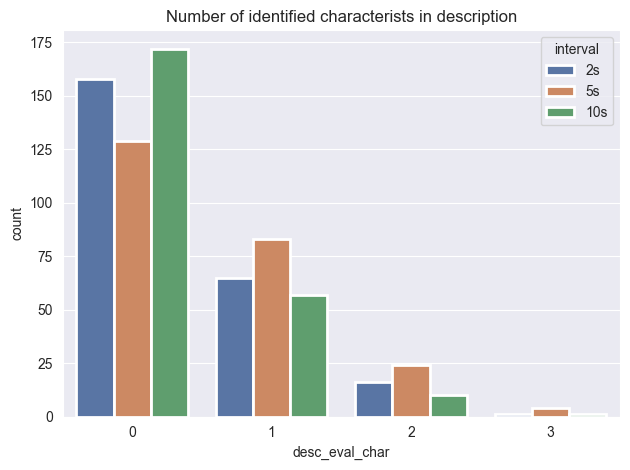

In [37]:
my_bar_grouped(data, 'desc_eval_char', 'interval', open_text['desc_eval_char'], ['2s', '5s', '10s'])

In [38]:
my_chi(fixed_data, 'desc_eval_char', 'interval', {2: [3]})

interval        10s   2s   5s
desc_eval_char               
0               172  156  129
1                57   62   83
2                11   16   28

----> pvalue: 0.0005149112007675257

expected frequencies:
[[153.61344538 149.77310924 153.61344538]
 [ 67.89915966  66.20168067  67.89915966]
 [ 18.48739496  18.02521008  18.48739496]]

Post-hoc testing:
('10s', '2s')        0.22069958242196447                   0
('10s', '5s')       0.00030593795804534075                   1
('2s', '5s')        0.012445929306744586                   1





**Sum of previous**

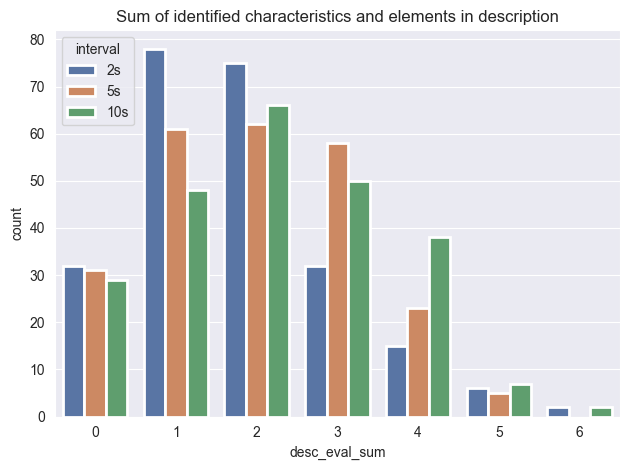

In [39]:
my_bar_grouped(data, 'desc_eval_sum', 'interval', open_text['desc_eval_sum'], ['2s', '5s', '10s'])

In [40]:
my_chi(fixed_data, 'desc_eval_sum', 'interval', {1: [2], 3: [4, 5, 6]})

interval         10s     2s     5s
desc_eval_sum                     
0               29.0   32.0   31.0
1              114.0  151.0  123.0
3               97.0   51.0   86.0

----> pvalue: 0.0003530045926383544

expected frequencies:
[[ 30.92436975  30.1512605   30.92436975]
 [130.42016807 127.15966387 130.42016807]
 [ 78.65546218  76.68907563  78.65546218]]

Post-hoc testing:
('10s', '2s')       0.00017159746611411001                   1
('10s', '5s')         0.4713811850573429                   0
('2s', '5s')        0.0028241653015279654                   1





**Description complexity**

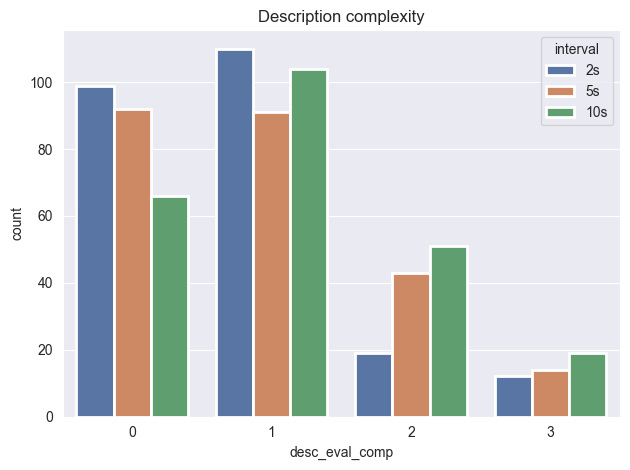

In [41]:
my_bar_grouped(data, 'desc_eval_comp', 'interval', open_text['desc_eval_comp'], ['2s', '5s', '10s'])

In [42]:
my_chi(fixed_data, 'desc_eval_comp', 'interval')

interval        10s   2s  5s
desc_eval_comp              
0                66   99  92
1               104  108  91
2                51   16  43
3                19   11  14

----> pvalue: 5.491127532688704e-05

expected frequencies:
[[ 86.38655462  84.22689076  86.38655462]
 [101.8487395   99.30252101 101.8487395 ]
 [ 36.97478992  36.05042017  36.97478992]
 [ 14.78991597  14.42016807  14.78991597]]

Post-hoc testing:
('10s', '2s')       1.748599196443424e-05                   1
('10s', '5s')        0.03153329385584009                   1
('2s', '5s')        0.0024702875018488067                   1





**Time intervals for tasks:**

In [43]:
data[['time']].mean()

time    135.410236
dtype: float64

In [44]:
data[['time', 'interval']].groupby(['interval']).mean()

time
interval            
10s       141.620833
2s        130.475000
5s        134.134875

## Word clouds

In [45]:
texts = {
    1: {'2s': '', '5s': '', '10s': ''},
    2: {'2s': '', '5s': '', '10s': ''},
    3: {'2s': '', '5s': '', '10s': ''},
    4: {'2s': '', '5s': '', '10s': ''},
    5: {'2s': '', '5s': '', '10s': ''},
    6: {'2s': '', '5s': '', '10s': ''},
}

for index, row in data.iterrows():
    texts[row.task][row.interval] += (row.desc_tokens + ' ') if type(row.desc_tokens) == str else ''

task 1
interval 2s


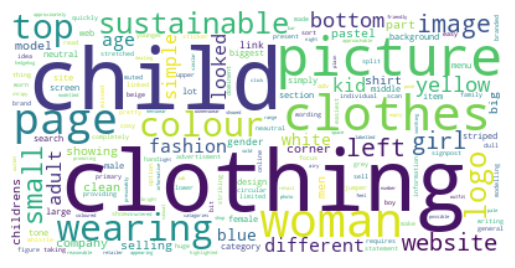

interval 5s


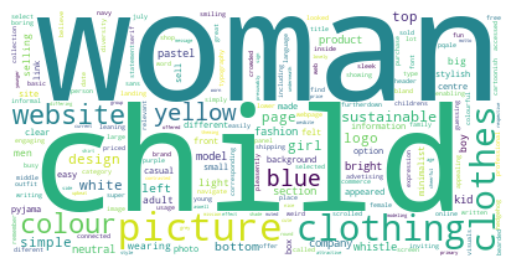

interval 10s


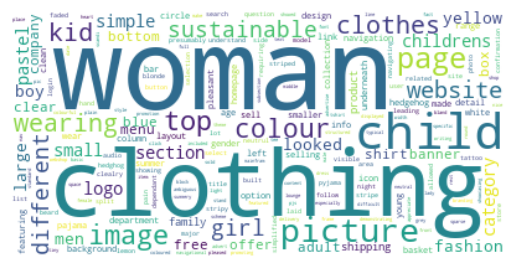

task 2
interval 2s


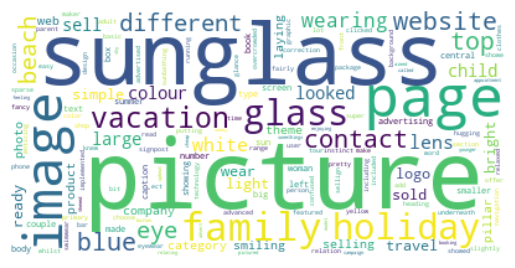

interval 5s


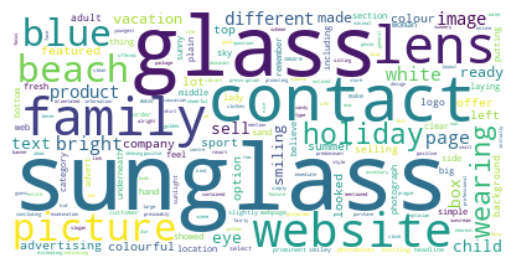

interval 10s


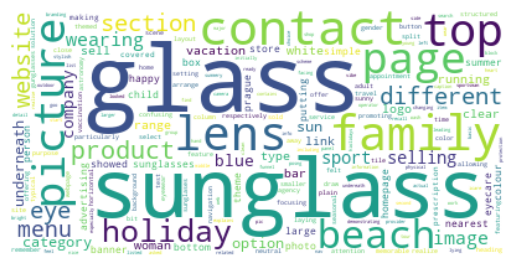

task 3
interval 2s


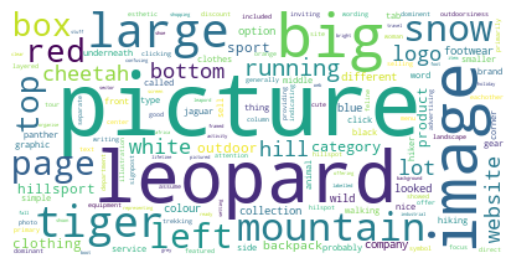

interval 5s


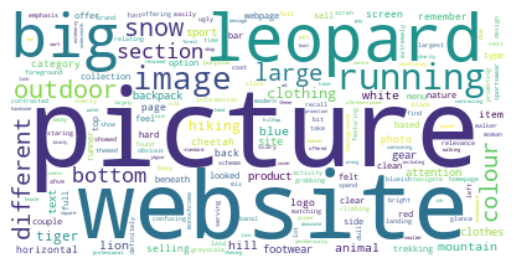

interval 10s


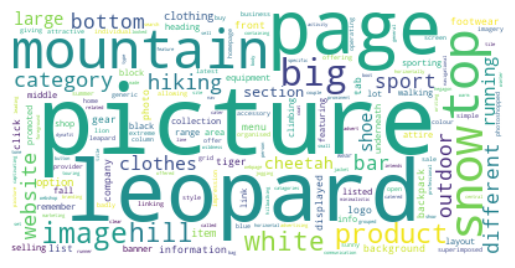

task 4
interval 2s


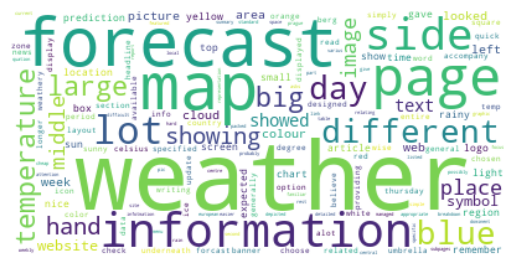

interval 5s


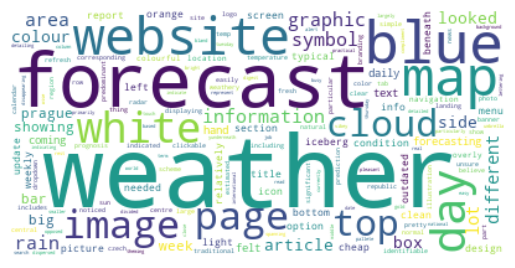

interval 10s


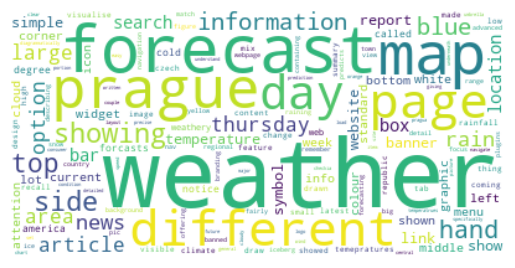

task 5
interval 2s


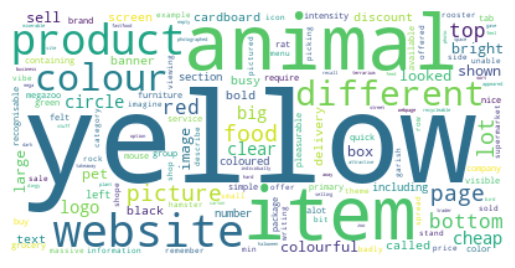

interval 5s


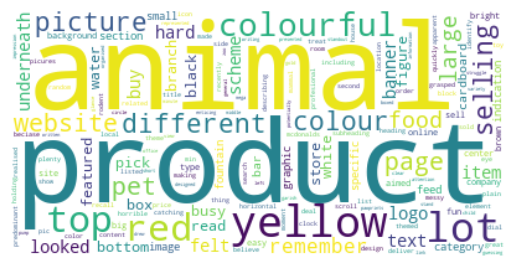

interval 10s


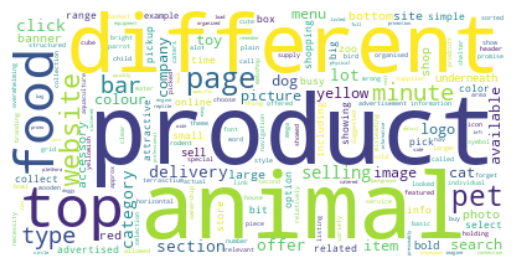

task 6
interval 2s


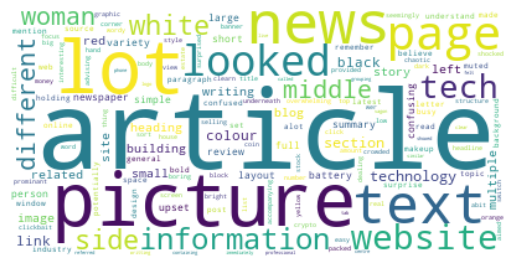

interval 5s


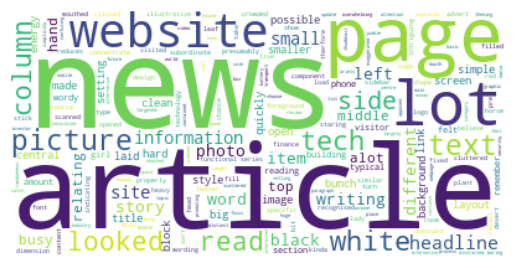

interval 10s


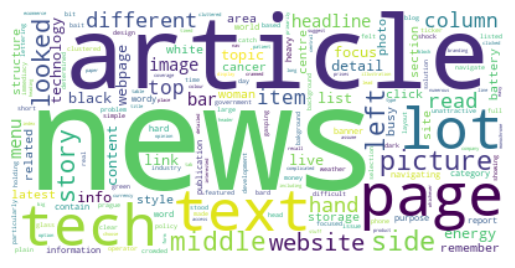

In [46]:
for task in texts:
    print('task ' + str(task))
    for interval in texts[task]: 
        print('interval ' + str(interval))
        fig, ax = plt.subplots()
        plt.imshow(WordCloud(collocations = False, background_color = 'white').generate(texts[task][interval]), interpolation='bilinear')
        plt.axis("off")
        plt.show()

In [47]:
for task in texts:
    print('task ' + str(task))
    for interval in texts[task]: 
        print(' interval ' + interval)
        print(sorted(WordCloud(collocations = False).process_text(texts[task][interval]).items(), key=lambda item: -item[1])[0:15])
    print() 

task 1
 interval 2s
[('child', 19), ('clothing', 19), ('picture', 16), ('clothes', 13), ('woman', 12), ('page', 12), ('wearing', 11), ('colour', 11), ('top', 11), ('logo', 8), ('sustainable', 8), ('small', 7), ('left', 6), ('image', 6), ('website', 6)]
 interval 5s
[('woman', 22), ('child', 19), ('picture', 17), ('clothing', 15), ('clothes', 14), ('website', 11), ('colour', 11), ('yellow', 8), ('blue', 7), ('sustainable', 7), ('page', 6), ('white', 6), ('simple', 6), ('logo', 6), ('girl', 6)]
 interval 10s
[('woman', 31), ('clothing', 19), ('child', 19), ('picture', 15), ('page', 12), ('top', 10), ('image', 10), ('colour', 9), ('clothes', 8), ('kid', 8), ('wearing', 8), ('website', 7), ('sustainable', 6), ('different', 6), ('girl', 6)]

task 2
 interval 2s
[('picture', 19), ('sunglass', 15), ('page', 12), ('image', 10), ('family', 10), ('holiday', 9), ('glass', 9), ('vacation', 8), ('website', 7), ('blue', 7), ('top', 7), ('contact', 7), ('beach', 6), ('different', 6), ('eye', 6)]
 int

In [48]:
word_differences = {
    1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}
}
significant_words = {
    1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}
}
for task in [1, 2, 3, 4, 5, 6]:
    words = texts[task]['2s'] + texts[task]['5s'] + texts[task]['10s']
    words_2s = sorted(WordCloud(collocations=False).process_text(texts[task]['2s']).items(),key=lambda item: -item[1])    
    words_5s = sorted(WordCloud(collocations=False).process_text(texts[task]['5s']).items(),key=lambda item: -item[1])    
    words_10s = sorted(WordCloud(collocations=False).process_text(texts[task]['10s']).items(),key=lambda item: -item[1])
    most_common_words = list(map(lambda x: x[0], sorted(WordCloud(collocations=False).process_text(words).items(),key=lambda item: -item[1])[0:15]))
    for word in most_common_words:
        word_differences[task][word] = [
            words_2s[[x[0] for x in words_2s].index(word)][1] if word in [x[0] for x in words_2s] else 0,
            words_5s[[x[0] for x in words_5s].index(word)][1] if word in [x[0] for x in words_5s] else 0,
            words_10s[[x[0] for x in words_10s].index(word)][1] if word in [x[0] for x in words_10s] else 0
        ]
        stat = stats.chisquare(word_differences[task][word])
        if(stat.pvalue < 0.05):
            significant_words[task][word] = word_differences[task][word]
            print('Task ' + str(task) + ', word "' + word + '", p = ' + str(stat.pvalue))

Task 1, word "woman", p = 0.015464151050698033
Task 1, word "image", p = 0.027647076357758687
Task 2, word "glass", p = 0.03498131642435014
Task 2, word "top", p = 0.02075433787369974
Task 3, word "page", p = 0.02075433787369974
Task 3, word "top", p = 0.011931522535756139
Task 4, word "website", p = 0.02144839925588929
Task 4, word "prague", p = 0.00011708251926008568
Task 6, word "news", p = 0.046523551526426815


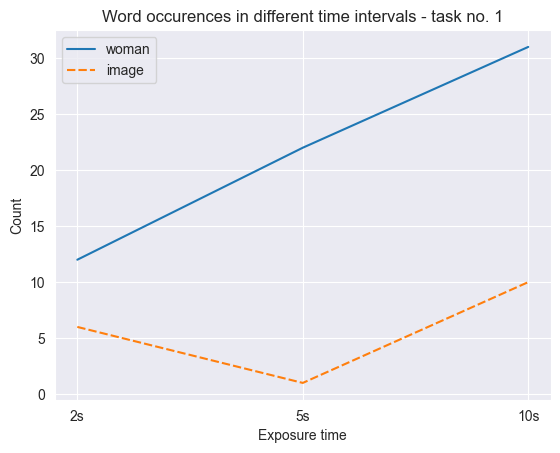

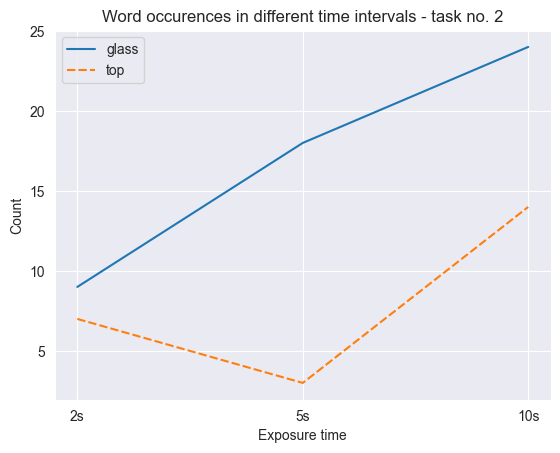

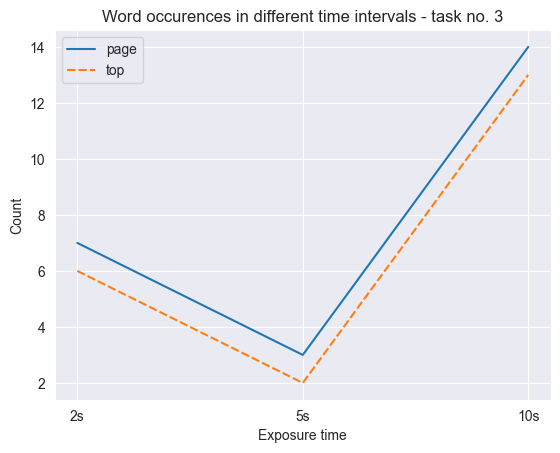

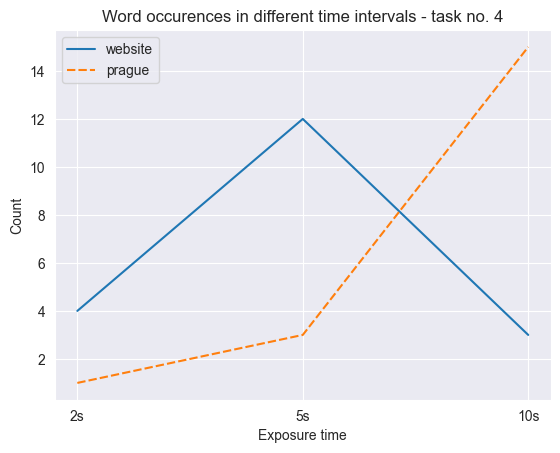

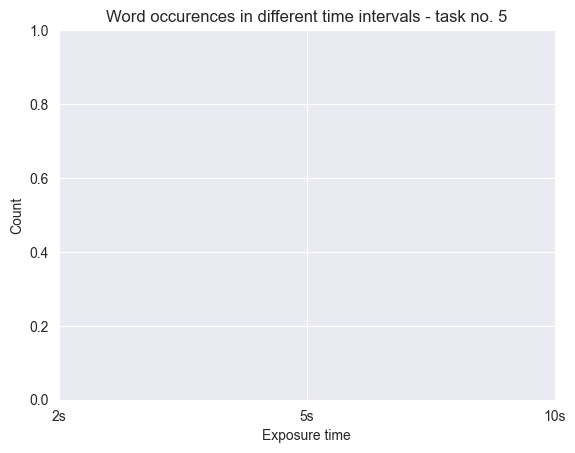

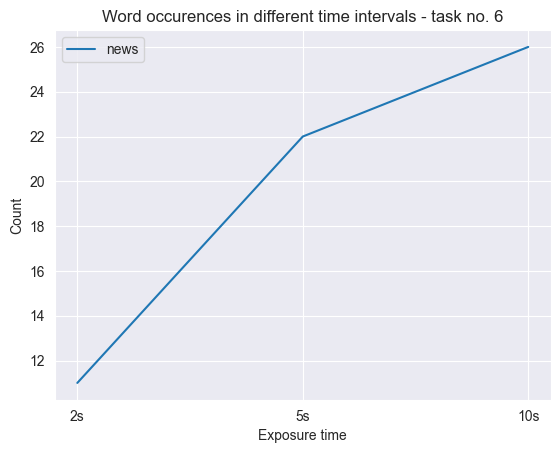

In [49]:
for task in [1, 2, 3, 4, 5, 6]:
    fig = sns.lineplot(data=significant_words[task])
    fig.set_xticks([0, 1, 2])
    fig.set_xticklabels(['2s','5s','10s'])
    fig.set_title('Word occurences in different time intervals - task no. ' + str(task))
    fig.set_xlabel('Exposure time')
    fig.set_ylabel('Count')
    plt.show()

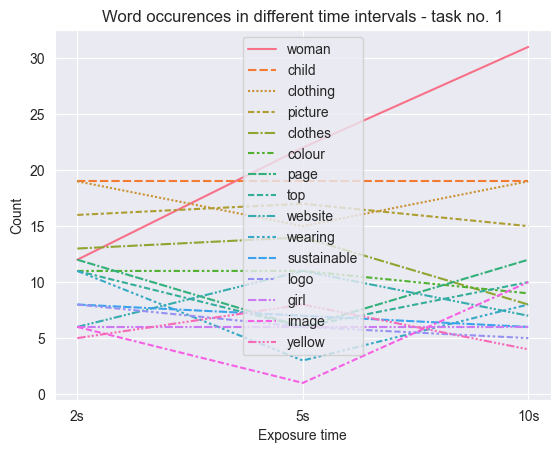

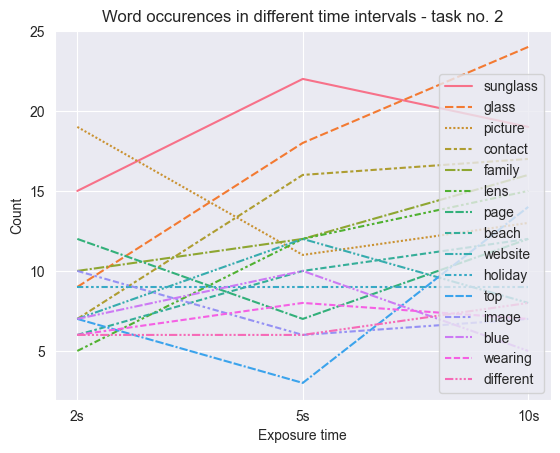

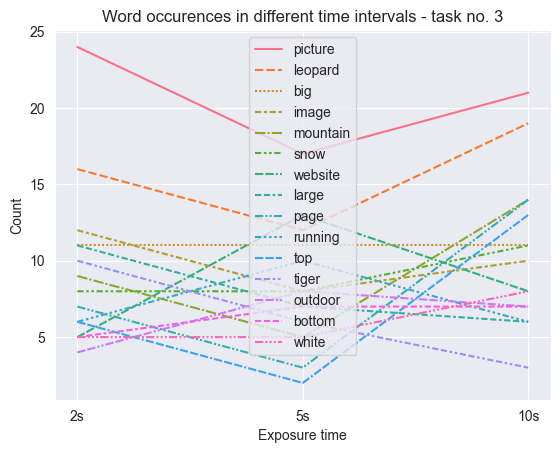

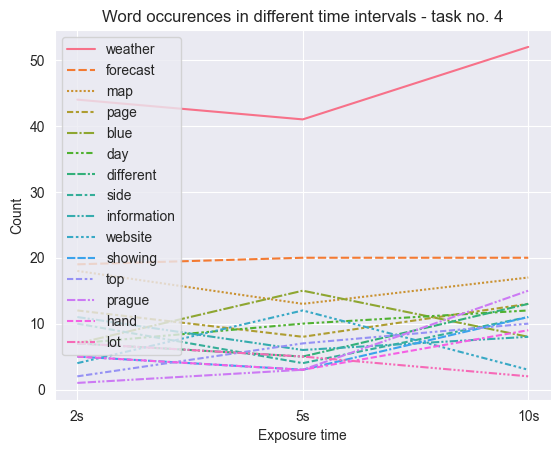

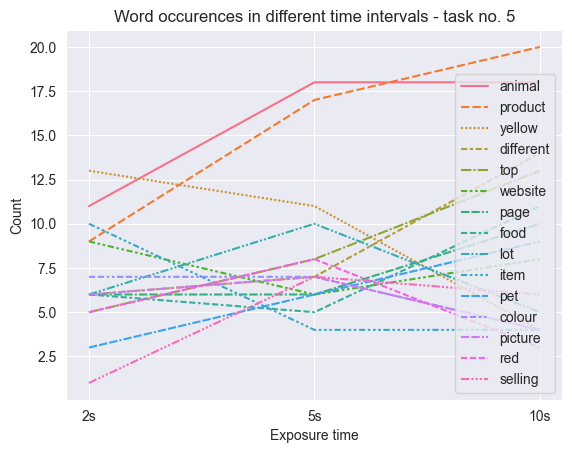

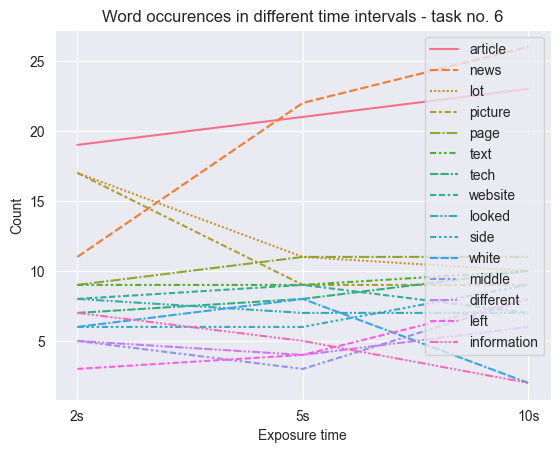

In [50]:
for task in [1, 2, 3, 4, 5, 6]:
    fig = sns.lineplot(data=word_differences[task])
    fig.set_xticks([0, 1, 2])
    fig.set_xticklabels(['2s','5s','10s'])
    fig.set_title('Word occurences in different time intervals - task no. ' + str(task))
    fig.set_xlabel('Exposure time')
    fig.set_ylabel('Count')
    plt.show()